<a href="https://colab.research.google.com/github/sinaabbasi1/machine-learning-and-deep-learning/blob/main/Assignments/Assignment%2004/ML_Assignment_04_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch import nn
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In this assignment, you will explore  Recurrent Neural Networks in more depth. An RNN is a part of the neural network's family used for processing sequential data such as text or audio. There are different types of RNNs concerning the number of inputs and outputs used in different problems. The figure below shows all of them. Based on the nature of the problem, one of these architecture comes in handy, for example:
* one to many: image captioning, where the input is an image and the output is a sequence of generated description words.
* many to one: sentiment analysis, given a sentence, the model should predict the sentiment, which means one output for a sequence of words.  
* many to many:  machine translation, where the input sequence is in some language, and the output sequence is in some other language (or POS tagging task).

In the first problem, you will write the loss function equation for a many-to-many RNN through baby steps. The second problem is implementation, where you are supposed to implement an LSTM cell yourself. For the next two problems, you will train models for two real-world problems using your own LSTM cell.


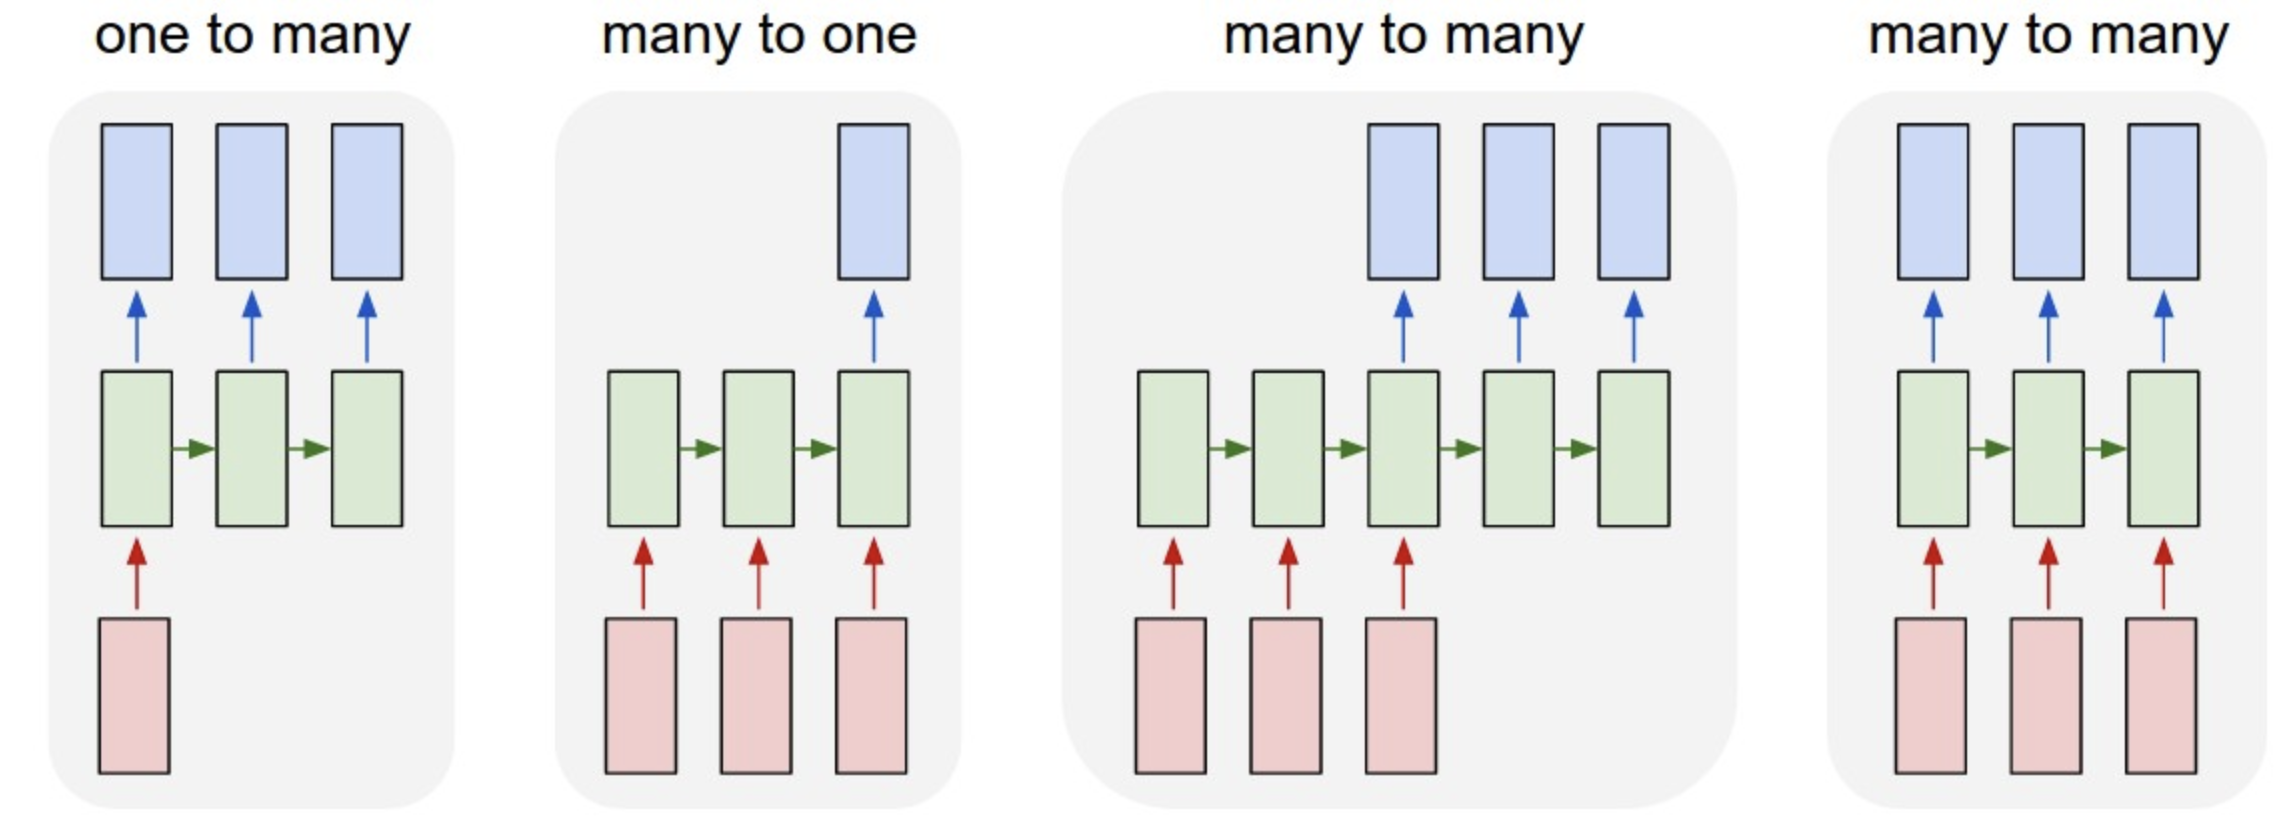

#Problem 1

Imagine, as shown in the image below, we want to build an RNN for a POS (part of speech) tagging task with 17 different labels, in which the model should predict the accurate tag for each word of input sequence based on the context of use.

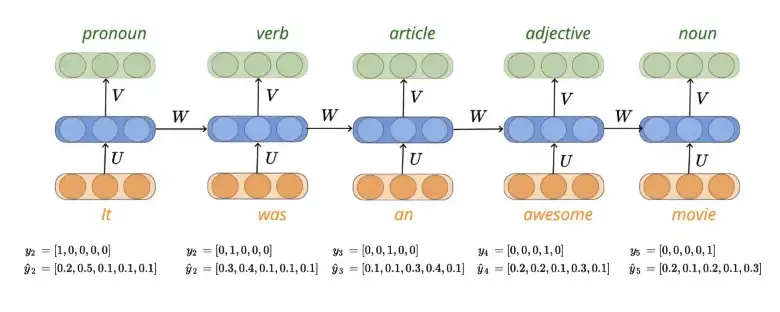

The architecture of our chosen RNN model is shown in the next image (the right one is unrolled form of the left RNN). The traditional approach to training deep networks is to do feed-forward and backpropagation continuously. But before all of it, we have to know how to calculate the loss function based on input data.

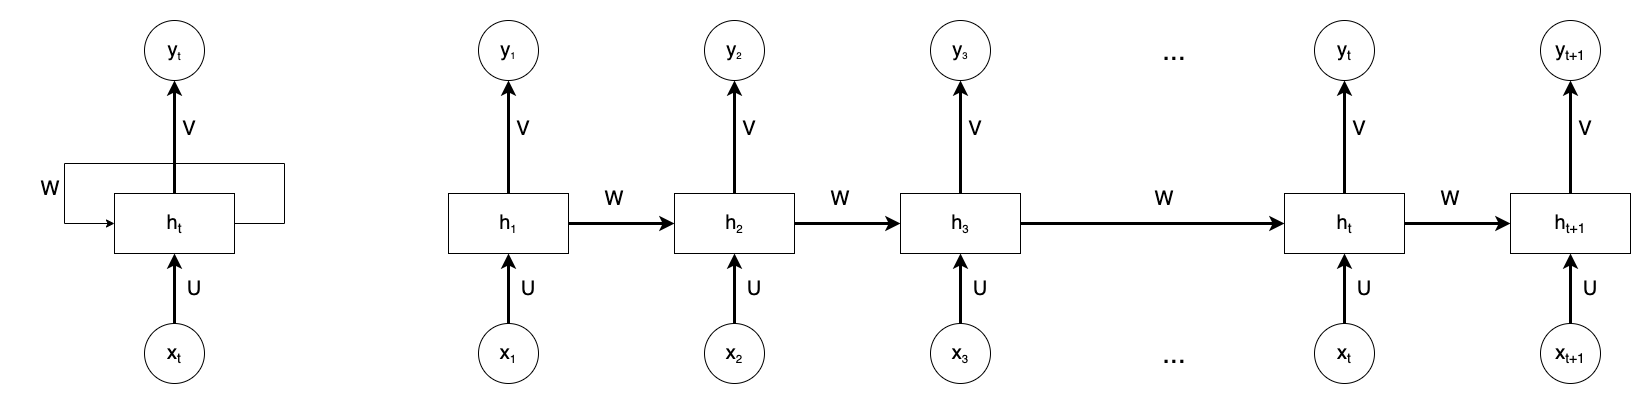


Since we have a prediction output per each timestep, the loss for a single input (a sequence of words) is the sum of each individual timestep's loss. So for a batch of size m, we have:
$$\begin{aligned}
Loss &= \frac{1}{m}\sum_{i}^{m}L(y^{(i)}, \hat{y}^{(i)}) \\
&= \frac{1}{m}\sum_{i}^{m}\sum^{T}_{t} L_t(y_t^{(i)},\hat{y}^{(i)}_{t})
\end{aligned}$$


Question: Use cross-entropy and write the equation of $L_t$ as a function of $y_t$ and $\hat{y}_t$. What is the dimension of $y_t$ and $\hat{y}_t$?

<font color='red'>Answer Here</font>

The dimension of $y_t$ and $\hat{y}_t$ is 17. Because, we have 17 different labels, which the model should predict the accurate tag for each word, we need 17 dimensions so we have 17 probabilities for each of labels.

$$\begin{aligned}
Loss &= \frac{1}{m}\sum_{i = 1}^{m}\sum^{T}_{t = 1} log(\hat{y}_{itc})
\end{aligned}$$

For the $i^{th}$ training example, for the $j^{th}$ time step, the logarithm value of predicted probability (of the index corresponding to the true class) is computed and the average is taken.




---



Question: As always, we use the softmax function to make $\hat{y}_t$ a probability distribution over all the classes. With this in mind and based on the notation used in the above image, write the equation of $\hat{y}_t$ as a function of $h_t$ and $V$. The size of the hidden unit is a hyperparameter that should be set when an RRN is instantiated. If $h \in \mathbb{R}^p$, then what would be the dimensions of $V$?



<font color='red'>Answer Here</font>


$$\begin{aligned}
o^{(t)} &= c + Vh^{(t)} \\
\hat{y}^{(t)} &= softmax(o^{(t)}) \\
\end{aligned}$$

Dimension of $V$:


$$V \in \mathbb{R}^{17 \times p}$$



---



Question: Following the mentioned arcitucture, determine the equation of $h_t$ where activation funcion is $tanh$. Given $X_t \in \mathbb{R}^d$, specify the dimentions of $W$ and $U$.  

<font color='red'>Answer Here</font>

$$\begin{aligned}
a^{(t)} &= b + Wh^{(t-1)} + Ux^{(t)} \\
h^{(t)} &= tanh(a^{(t)}) \\
\end{aligned}$$

Dimension of $W$ and $U$:

$$W \in \mathbb{R}^{p \times p}$$

$$U \in \mathbb{R}^{p \times d}$$



---



"RNNs suffer from the problem of vanishing gradients, which hampers learning of long data sequences; in other words, RNNs cannot memorize data for a long time and begin to forget their previous inputs. The gradients carry information used in the RNN parameter update, and when the gradient becomes smaller and smaller, the parameter updates become insignificant, which means no real learning is done."


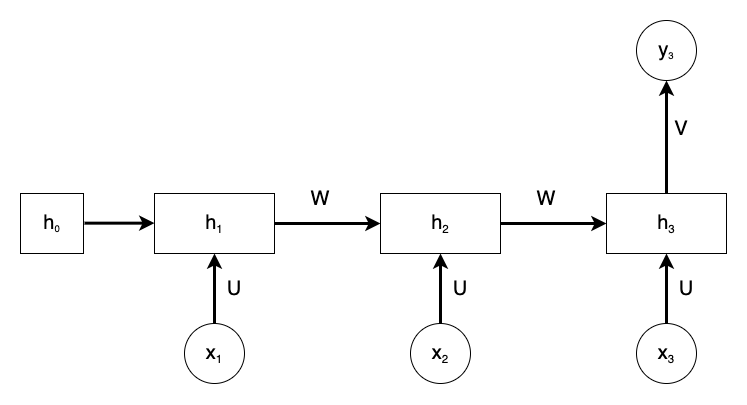


To see this phenomenon, let's calculate the gradients. Assume the length of the input sequence is $3$, as is shown in the image above, calculate the derivation of $L_3$ wrt $U$. (To do so, it is enough to calculate $\frac {\partial h_3}{\partial U}$)


$$\begin{aligned}
\frac{\partial L_3}{\partial U} = \frac{\partial L_3}{\partial \hat{y}_3} \times \frac{\partial \hat{y}_3} {\partial h_3} \times \frac {\partial h_3}{\partial U}
\end{aligned}$$

Based on it, explain gradient vanishing for $X_1$.

Hint: write $\frac {\partial h_3}{\partial U}$ in form of $G_3X_3 + G_2X_2 + G_1X_1$



<font color='red'>Answer Here</font>

We know that the hidden state $h_3$ partially depends also on $h_t$ according to the recursive formulation. So, we have:

$$\begin{aligned}
\frac{\partial L_3}{\partial U} = \frac{\partial L_3}{\partial \hat{y}_3} \times \frac{\partial \hat{y}_3} {\partial h_3} \times \frac {\partial h_3}{\partial h_2} \times \frac {\partial h_2}{\partial U}
\end{aligned}$$

Again, $h_2$ partially depends on $h_1$ and so on.

$$\begin{aligned}
\frac{\partial L_3}{\partial U} = \frac{\partial L_3}{\partial \hat{y}_3} \times \frac{\partial \hat{y}_3} {\partial h_3} \times \frac {\partial h_3}{\partial h_2} \times \frac {\partial h_2}{\partial h_1} \times \frac {\partial h_1}{\partial U}
\end{aligned}$$

Also, for each of $\frac{\partial h_{j+1}}{\partial h_j}$ we have:

$$\frac{\partial h_{j+1}}{\partial h_{j}} = diag(\phi_{h}^{\prime}(U \cdot X_{j+1} + W^{T}\cdot h_{j} +b_{h})W$$

Where $\phi_{h}^{\prime}$ is commenly $tanh$ and $diag$ turns a vector into a diagonal matrix because this recursive partial derivative is a Jacobian matrix. Thus, if we want to backpropagate through previous timesteps, this gradient will be:

$$\prod^{2}_{j=0} \frac{\partial h_{j+1}}{\partial h_{j}} = \prod^{2}_{j=0} diag(\phi_{h}^{\prime}(U \cdot X_{j+1} + W^{T}\cdot h_{j} +b_{h})W$$

Since we’re multiplying over and over again by the weight matrix and if weight matrix $W$ is small then we are going to have vanishing gradient descent.

Beside of previous reason, the gradient passes through the $tanh$ non-linearity which has saturating regions at the extremes. It means the gradient will essentially become zero if it has a high or low value once it passes through the non-linearity — so the gradient cannot propagate effectively across long sequences and it leads to ineffective optimization.

#Problem 2

Since simple RNNs suffer from forgetting early inputs in long sequences, another network called Long-Short-Term-Memory was introduced to solve it. Explain how LSTM mitigated this problem. (No need for mathematics proof)


<font color='red'>Answer Here</font>

In RNN when a new information is added RNN completely modifies the existing information. In LSTM we have long-term memory. So the modification on long-term memory is based on the importance of the information. In the forget gate we decide what percentage of information to be remembered. And you can see there is nothing in the way of long-term memory so it is good solution to vanishing and exploding gradient descent. There is some other gates in the LSTM unit like input gate which update the value of long-term memory with some percentage of potential long-term memory using the input data. At last, in the output gate, LSTM unit decide what percentage of new long-term memory is considered as the short-term memory to the next unit.


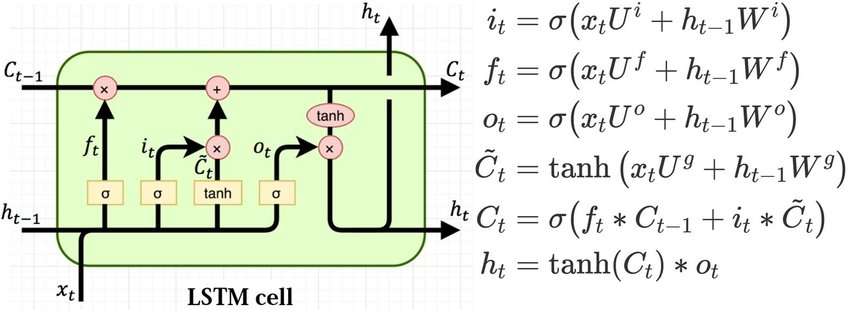

Architecture of an LSTM cell is shown in the image above, using that complete the code below to have a LSTM cell. As long as your LSTM cell works correctly, you do not have to stick to the provided prototype. Implement it however you are comfortable with.  

In [ ]:
import torch
import math
from torch import nn

class LSTM_cell(torch.nn.Module):

    def __init__(self, input_length=10, hidden_length=20):
        super(LSTM_cell, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length

        #initialization

        # input gate components
        self.linear_input_gate_Wi = torch.normal(0, 1, size=(hidden_length, hidden_length), dtype=torch.float64).to(device)
        self.linear_input_gate_Ui = torch.normal(0, 1, size=(input_length, hidden_length), dtype=torch.float64).to(device)
        # self.sigmoid_input_gate = nn.Sigmoid

        # forget gate components
        self.linear_forget_gate_Wf = torch.normal(0, 1, size=(hidden_length, hidden_length), dtype=torch.float64).to(device)
        self.linear_forget_gate_Uf = torch.normal(0, 1, size=(input_length, hidden_length), dtype=torch.float64).to(device)
        # self.sigmoid_forget_gate = nn.Sigmoid

        # cell memory components
        self.linear_gate_Wg = torch.normal(0, 1, size=(hidden_length, hidden_length), dtype=torch.float64).to(device)
        self.linear_gate_Ug = torch.normal(0, 1, size=(input_length, hidden_length), dtype=torch.float64).to(device)
        # self.activation_gate = nn.Tan

        # out gate components
        self.linear_output_gate_Wo = torch.normal(0, 1, size=(hidden_length, hidden_length), dtype=torch.float64).to(device)
        self.linear_outptu_gate_U0 = torch.normal(0, 1, size=(input_length, hidden_length), dtype=torch.float64).to(device)
        # self.sigmoid_out_gate = nn.Parameter(torch.Tensor(hidden_length))

        # print('w_i', self.linear_input_gate_Wi)
        self.activation_final = nn.Tanh()


    def forget_gate(self, x, h_prev):

        f = torch.sigmoid(x @ self.linear_forget_gate_Uf + h_prev @ self.linear_forget_gate_Wf)
        return f

    def input_gate(self, x, h_prev):
        i = torch.sigmoid(x @ self.linear_input_gate_Ui + h_prev @ self.linear_input_gate_Wi)
        return i

    def out_gate(self, x, h_prev):

        o = torch.sigmoid(x @ self.linear_outptu_gate_U0 + h_prev @ self.linear_output_gate_Wo)
        return o

    def cell_memory_gate(self, x, h_prev, i, f, C_prev):

        # g as c~
        g = torch.tanh(x @ self.linear_gate_Ug + h_prev @ self.linear_gate_Wg)
        C = torch.sigmoid(f * C_prev + i * g)
        return C

    def forward(self, x, tuple_in):
        (h_prev, C_prev) = tuple_in

        i = self.input_gate(x, h_prev)
        f = self.forget_gate(x, h_prev)
        o = self.out_gate(x, h_prev)
        c = self.cell_memory_gate(x, h_prev, i, f, C_prev)
        h = o * torch.tanh(c)

        return h, c

Now run the next three cells to check the sanity of your implantation. In this expremint using your LSTM cell we implement a two layer LSTM model. Given the observed values ​​of a Sine wave so far, the model should predict the next value of the wave.

In [ ]:
#building RNN model
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.rnn1 = LSTM_cell(1, 51)
        self.rnn2 = LSTM_cell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):

            h_t, c_t = self.rnn1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))

            output = self.linear(h_t2)
            outputs += [output]
            # print(len(outputs))

        outputs = torch.stack(outputs, 1).squeeze(2)
        # print(outputs.shape)
        return outputs


In [ ]:
a = np.array(range(1000))
np.random.randint(-4 * 20, 4 * 20, 200).shape
b = np.random.randint(-4 * 20, 4 * 20, 200).reshape(200, 1)

print(a)
print(a.shape)
print(b)
print(b.shape)
print(a + b)
print((a + b).shape)

In [ ]:
#generating Data

np.random.seed(2)

T = 20
L = 1000
N = 200

#generate 200 sin wave with length 1000
x = np.empty((N, L), 'int64')
print(x.shape)
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
print(x.shape)
data = np.sin(x / 1.0 / T).astype('float64')
print(data)
#keep the first three waves for test
input = torch.from_numpy(data[3:, :-1]).to(device)
print(input.shape)
target = torch.from_numpy(data[3:, 1:]).to(device)
print(target.shape)
test_input = torch.from_numpy(data[:3, :-1]).to(device)
print(test_input.shape)
test_target = torch.from_numpy(data[:3, 1:]).to(device)
print(test_target.shape)

(200, 1000)
(200, 1000)
[[ 0.10819513  0.05837414  0.00840725 ...  0.50025202  0.45635088
   0.4113091 ]
 [-0.38941834 -0.34289781 -0.29552021 ... -0.72805642 -0.69288495
  -0.65598164]
 [-0.23924933 -0.28747801 -0.33498815 ...  0.17301479  0.12357312
   0.07382259]
 ...
 [ 0.09983342  0.14943813  0.19866933 ... -0.31027515 -0.26237485
  -0.21381875]
 [-0.04997917  0.          0.04997917 ... -0.44885398 -0.40363139
  -0.35739993]
 [-0.61185789 -0.65062514 -0.68776616 ... -0.24054266 -0.28875375
  -0.33624311]]
torch.Size([197, 999])
torch.Size([197, 999])
torch.Size([3, 999])
torch.Size([3, 999])


In [ ]:
#instantiates model and train it

seq = Sequence()
seq.to(device)

seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
# begin to train
for epoch in range(4):
    print('STEP: ', epoch)

    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss

    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_input)
        loss = criterion(pred, test_target)
        print('test loss:', loss.item())
        y = pred.cpu().detach().numpy()

STEP:  0
loss: 0.5096469928536884
loss: 0.43399039776161247
loss: 0.11528284040179072
loss: 0.1106633309519599
loss: 0.02998661390533508
loss: 0.026374996743411414
loss: 0.02618507444286016
loss: 0.026123810932782633
loss: 0.025975155421697805
loss: 0.025640472092018012
loss: 0.02490433823261394
loss: 0.023407830345916928
loss: 0.020824395726568367
loss: 0.01754873719721775
loss: 0.013630976548917585
loss: 0.012319405465040642
loss: 0.012067614056402687
loss: 0.011788512388766189
loss: 0.01119078075292917
loss: 0.010011687485428165
test loss: 0.00795694542931534
STEP:  1
loss: 0.00802589967423252
loss: 0.005610668164592418
loss: 0.0038350543037939636
loss: 0.0031913342433995922
loss: 0.0030746022770168835
loss: 0.0030617210410169523
loss: 0.00306035977263501
loss: 0.003059387053721999
loss: 0.0030552789000200856
loss: 0.0030448748874489584
loss: 0.0030206680413323726
loss: 0.002965812658238803
loss: 0.0028460802377060705
loss: 0.002605107498255159
loss: 0.002195889728680732
loss: 0.001

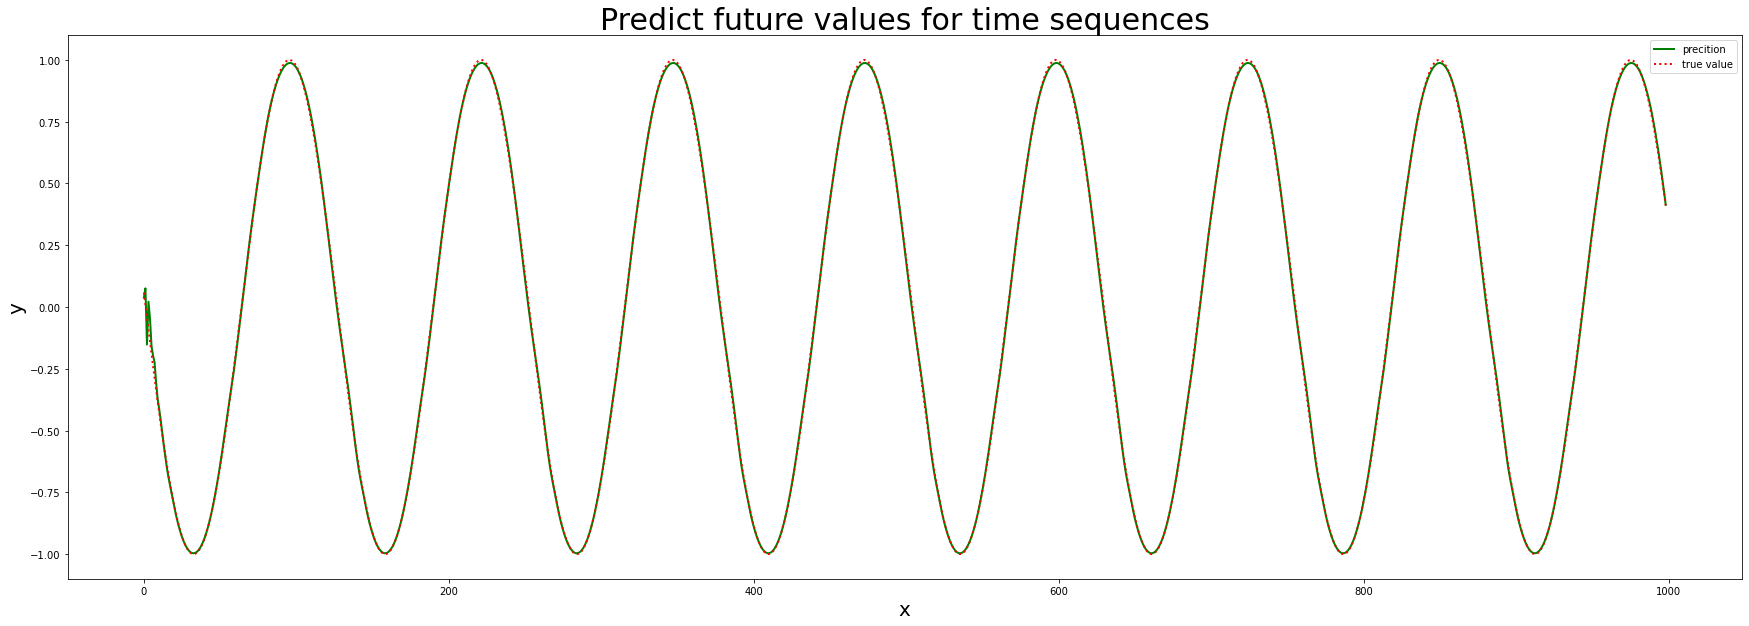

In [ ]:
def draw(predict, y):
        plt.figure(figsize=(30, 10))
        plt.title('Predict future values for time sequences', fontsize=30)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.plot(np.arange(input.cpu().size(1)), predict[:input.size(1)], 'g', linewidth=2.0, label='precition')
        plt.plot(np.arange(input.cpu().size(1)), y.cpu()[:input.cpu().size(1)], 'r:', linewidth=2.0, label='true value')
        plt.legend()

#test 1
draw(y[0], test_target[0])

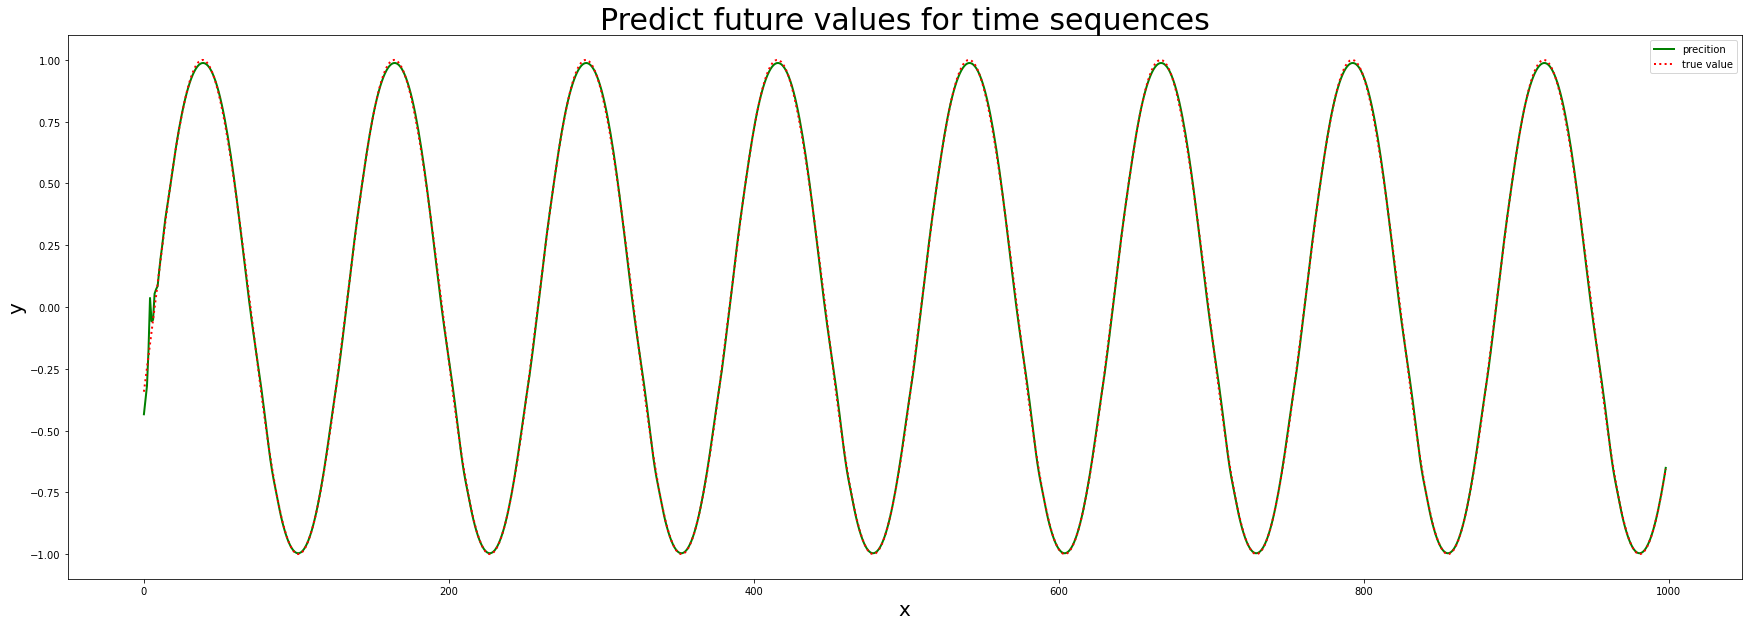

In [ ]:
#test 1
draw(y[1], test_target[1])

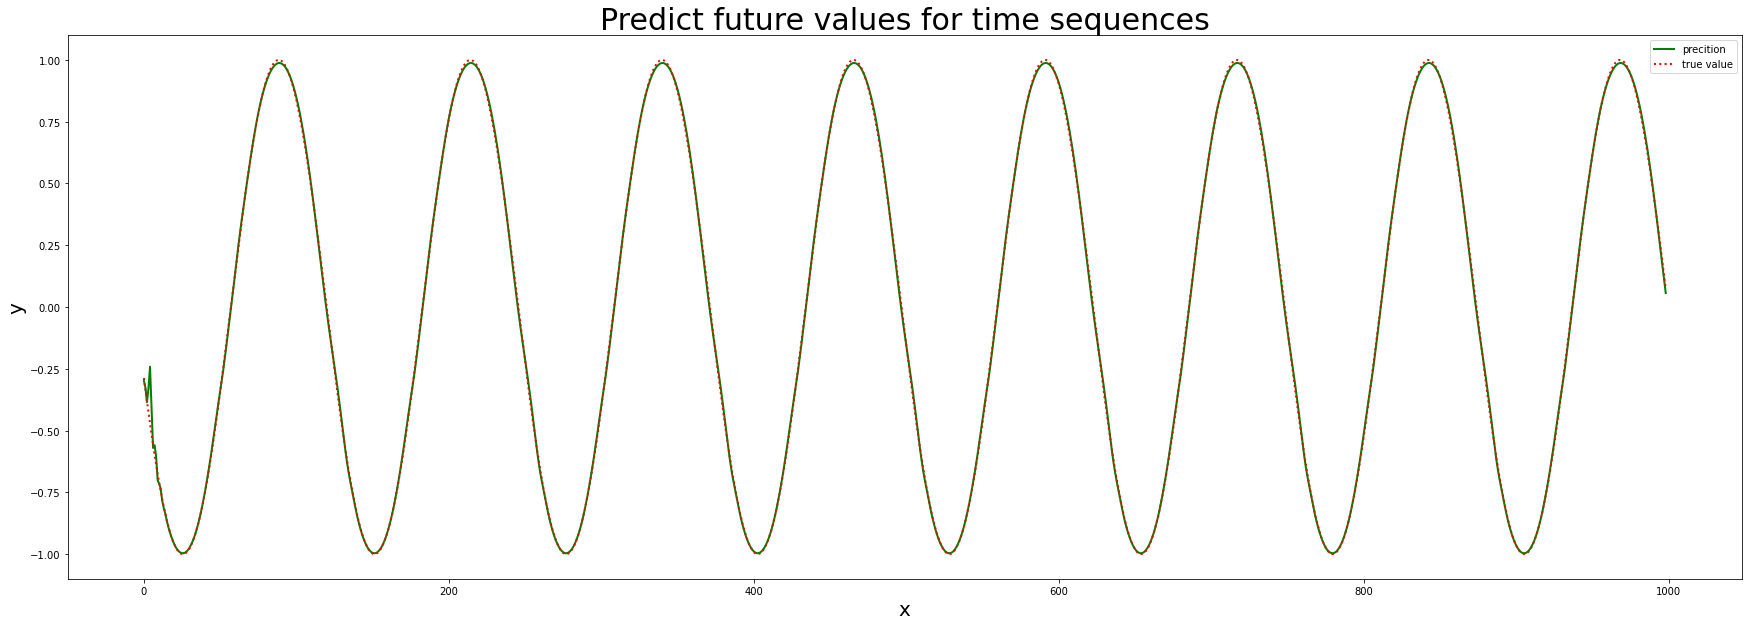

In [ ]:
#test 1
draw(y[2], test_target[2])

#Problem 3


In this problem, you will build and train a model using your own LSTM cell to predict the stock market.

Use the test and training datasets provided and build a model with the appropriate architecture of your choice. The only limitation is that you must use your own implemented LSTM cell. Each data input is information from 59 consecutive days, and your model should be able to predict the next day's prices as accurately as possible.

In [ ]:
import pandas as pd

In [ ]:
# Read data
df = pd.read_csv('NVDA.csv')
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.NVDA,D,20101004,0,11.24,11.430,11.01,11.23,18184874
1,US1.NVDA,D,20101005,0,11.48,11.500,11.29,11.32,18266877
2,US1.NVDA,D,20101006,0,11.32,11.370,10.67,10.78,25753399
3,US1.NVDA,D,20101007,0,10.82,10.840,10.38,10.70,18732301
4,US1.NVDA,D,20101008,0,10.65,10.950,10.51,10.86,16998198
...,...,...,...,...,...,...,...,...,...
2762,US1.NVDA,D,20210927,0,217.16,217.750,213.28,216.57,625939
2763,US1.NVDA,D,20210928,0,212.01,214.030,206.51,207.02,835341
2764,US1.NVDA,D,20210929,0,209.33,210.160,204.68,205.22,606902
2765,US1.NVDA,D,20210930,0,207.89,210.650,206.89,207.12,537697


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df.iloc[:, 4:])
df_scaler = scaler.transform(df.iloc[:, 4:])
df_scaler

dfff = pd.DataFrame(df_scaler, columns = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>'])
result = pd.concat([df.iloc[:, :4], dfff], axis=1, join='inner')

result

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.NVDA,D,20101004,0,-0.736067,-0.736126,-0.736424,-0.736213,1.096887
1,US1.NVDA,D,20101005,0,-0.734623,-0.735711,-0.734710,-0.735672,1.106888
2,US1.NVDA,D,20101006,0,-0.735586,-0.736482,-0.738506,-0.738922,2.019910
3,US1.NVDA,D,20101007,0,-0.738596,-0.739624,-0.740281,-0.739403,1.163649
4,US1.NVDA,D,20101008,0,-0.739619,-0.738972,-0.739485,-0.738440,0.952165
...,...,...,...,...,...,...,...,...,...
2762,US1.NVDA,D,20210927,0,0.503539,0.487300,0.501829,0.499744,-1.044522
2763,US1.NVDA,D,20210928,0,0.472537,0.465242,0.460384,0.442262,-1.018984
2764,US1.NVDA,D,20210929,0,0.456404,0.442294,0.449181,0.431428,-1.046844
2765,US1.NVDA,D,20210930,0,0.447735,0.445199,0.462710,0.442864,-1.055284


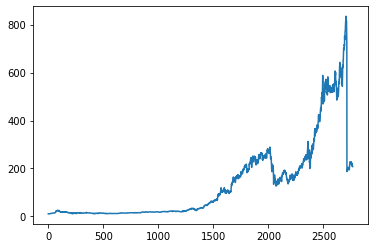

In [ ]:
plt.plot(df['<OPEN>'])

In [ ]:
from sklearn.preprocessing import StandardScaler

# create train and test data
def load_data(stock, window_size):

    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler()
    scaler.fit(stock.iloc[:, 4:])
    stock_scaler = scaler.transform(stock.iloc[:, 4:])
    stock_scaler = pd.DataFrame(stock_scaler, columns = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>'])
    stock = pd.concat([df.iloc[:, :4], stock_scaler], axis=1, join='inner')

    data_raw = stock.values # convert to numpy array (2767 x 9)
    data = []

    # create all possible sequences of length window_size
    for index in range(len(data_raw) - window_size):
        data.append(data_raw[index: index + window_size, 4:])

    data = np.array(data); # data.shape = (2707 x 60 x 5)
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,0]

    return [x_train, y_train, x_test, y_test]

window_size = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, window_size)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2166, 59, 5)
y_train.shape =  (2166,)
x_test.shape =  (541, 59, 5)
y_test.shape =  (541,)


In [ ]:
y_train

array([-0.7134326773854989, -0.7138540664952636, -0.7139142649395157, ...,
       0.16660837913600557, 0.12170033972393614, 0.122121728833701],
      dtype=object)

In [ ]:
x_train = torch.tensor(x_train.astype(np.float64)).to(device)
y_train = torch.tensor(y_train.astype(np.float64)).to(device)
x_test = torch.tensor(x_test.astype(np.float64)).to(device)
y_test = torch.tensor(y_test.astype(np.float64)).to(device)

In [ ]:
# Build model
#####################

class Problem_3(nn.Module):
    def __init__(self):
        super(Problem_3, self).__init__()
        self.rnn1 = LSTM_cell(5, 51)
        self.rnn2 = LSTM_cell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)): # input.size(1) = 59

            input_t = input_t.squeeze()

            h_t, c_t = self.rnn1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))

            output = self.linear(h_t2)
            # print(output.shape)
            outputs += [output]
            # print(len(outputs))
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs[:,58]

In [ ]:
len(x_train.chunk(input.size(1), dim=1))

59

In [ ]:
x_train.chunk(input.size(1), dim=1)[0].squeeze().shape

torch.Size([2166, 5])

In [ ]:
t = torch.empty(2, 3, 4)
print(t)
print('----------------')
print(t.chunk(6)[1])
print('----------------')
print(t.chunk(6)[1].squeeze(2))

In [ ]:
# Train model
#####################

loss_train = list()
loss_test = list()

seq = Problem_3()
seq.to(device)

seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
# begin to train
for epoch in range(20):
    print('STEP: ', epoch)

    loss_per_epoch_train = list()
    # loss_per_epoch_test = list()

    def closure():
        optimizer.zero_grad()
        out = seq(x_train)
        # print(out.shape, '****', y_train.shape)
        loss = criterion(out, y_train)
        print('loss:', loss.item())
        loss.backward()
        loss_per_epoch_train.append(loss.item())
        return loss

    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(x_test)
        # print(pred.shape, '****', y_test.shape)
        loss = criterion(pred, y_test)
        loss_test.append(loss.item())
        print('test loss:', loss.item())
        y = pred.cpu().detach().numpy()

    loss_train.append(loss_per_epoch_train)
    # loss_test.append(loss_per_epoch_test)

STEP:  0
loss: 0.49682544695121095
loss: 0.2341517784177766
loss: 0.20206592144150132
loss: 0.1903625294225831
loss: 0.16410592365283067
loss: 0.11823283865862189
loss: 0.059213651713904136
loss: 0.01094506570773435
loss: 0.007080793845099181
loss: 0.006886787704645006
loss: 0.006872304810429937
loss: 0.0068660790574991025
loss: 0.006852513687513255
loss: 0.0068221941064636644
loss: 0.006756403348614571
loss: 0.006626397042078948
loss: 0.0064135350351436195
loss: 0.006152923763217555
loss: 0.005847079059036018
loss: 0.005499272075169269
test loss: 2.283789165317358
STEP:  1
loss: 0.005293098227138951
loss: 0.005066996588414801
loss: 0.004739112190822197
loss: 0.004283450898911133
loss: 0.003782675652860161
loss: 0.003537118862984624
loss: 0.0034854693392043002
loss: 0.003475655739802608
loss: 0.003471078493314026
loss: 0.0034621248621956556
loss: 0.0034404023738565086
loss: 0.003391794768917028
loss: 0.003289744636738158
loss: 0.0031021682885357675
loss: 0.002835096019160922
loss: 0.00

Text(0.5, 1.0, 'Train Loss based on epoch 4')

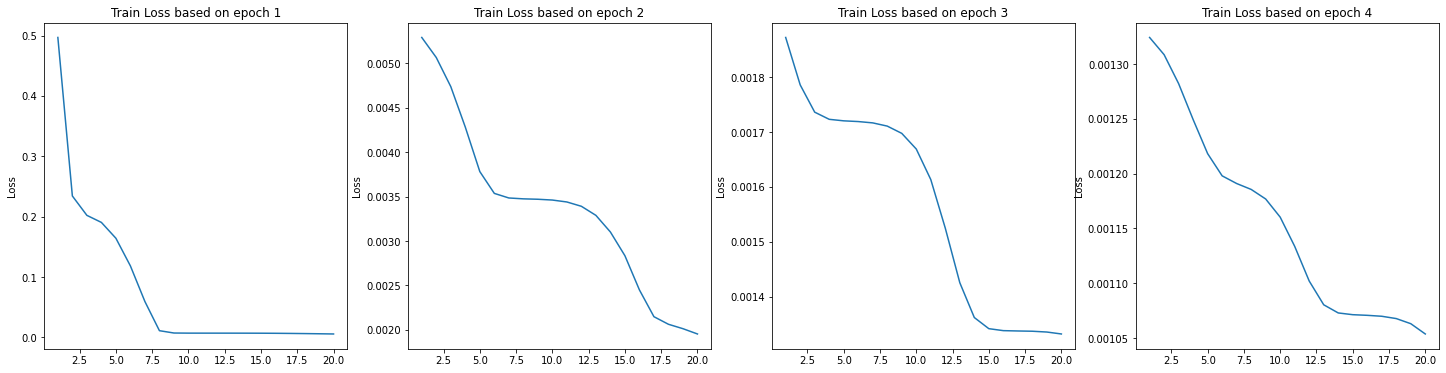

In [ ]:
# Plot loss based on epochs for both test and train
#####################

fig = plt.figure(figsize=(25, 6))

plt.subplot(1, 4, 1)
plt.plot(np.arange(1, 21, 1), loss_train[0], label='STEP: 0')
plt.ylabel('Loss')
plt.title('Train Loss based on epoch 1')

plt.subplot(1, 4, 2)
plt.plot(np.arange(1, 21, 1), loss_train[1], label='STEP: 1')
plt.ylabel('Loss')
plt.title('Train Loss based on epoch 2')

plt.subplot(1, 4, 3)
plt.plot(np.arange(1, 21, 1), loss_train[2], label='STEP: 2')
plt.ylabel('Loss')
plt.title('Train Loss based on epoch 3')

plt.subplot(1, 4, 4)
plt.plot(np.arange(1, 21, 1), loss_train[3], label='STEP: 3')
plt.ylabel('Loss')
plt.title('Train Loss based on epoch 4')


Text(0.5, 1.0, 'Test Loss based on epochs')

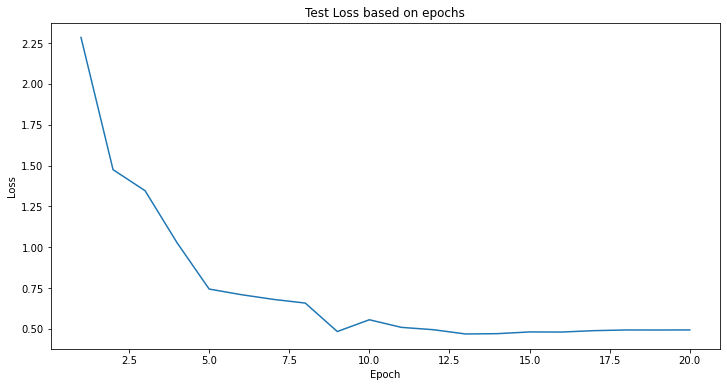

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.plot(np.arange(1, 21, 1), loss_test)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Test Loss based on epochs')

In [ ]:
# make predictions
#####################

with torch.no_grad():
    pred = seq(x_test)

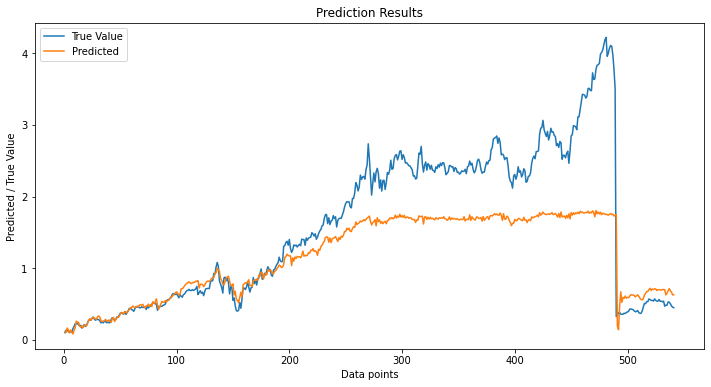

In [ ]:
# Visualising the prediction results
#####################

fig = plt.figure(figsize=(12, 6))

plt.plot(np.arange(1, 542, 1), y_test.tolist(), label='True Value')
plt.plot(np.arange(1, 542, 1), pred.tolist(), label='Predicted')
plt.ylabel('Predicted / True Value')
plt.xlabel('Data points')
plt.title('Prediction Results')
plt.legend()

#Problem 4


In this problem, we will train an LSTM network to generate Persian names. The model will see a sequence of characters corresponding to the names and will be trained with the objective of predicting the best next character for the given sequence. An overview of the model is illustrated in the picture below.

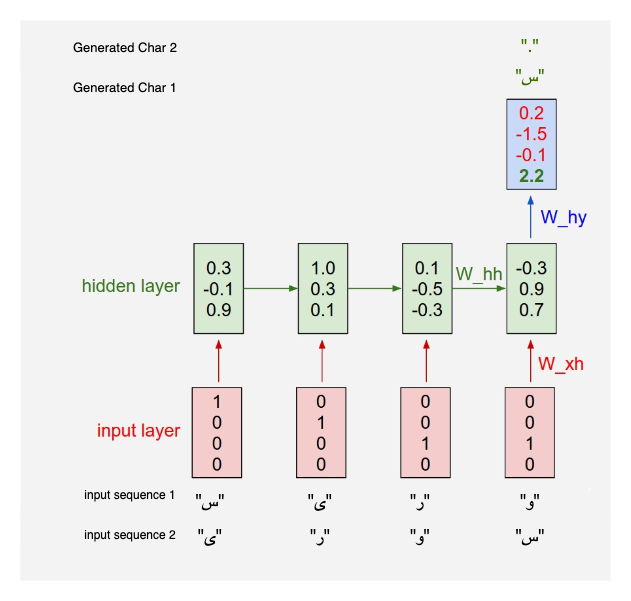

Quesrion: Teacher forcing is a technique used in training  of RNNs, study about it and explained it in your words.

<font color='red'>Answer Here</font>

In language models and sequence generation, we have $x^{⟨t⟩} = y^{⟨t-1⟩}$. It means that the output from last time step is the input for the current time step. This procedure can used when training the model, but it can cause some problems:

* Slow convergence
* Model instability
* Poor skill

**Teacher Forcing:** Teacher forcing is a technique in training recurrent neural networks, that uses *ground truth* as input, instead of model output from a prior time step. A famous example about Teacher Forcing is that consider in a mathematics exam you have multisection questions. First you answer part (a), but you don't know if your answer is right or wrong and if your answer is wrong then (b), (c), ... is going to be wrong too. But, if after answering part (a), the teacher check your answer and score what you have wrote and tell you the right answer, then you are only punished for the first part and you can continue to answer next parts based on the right answer of part (a).



Dataset `Persian_names` contains  ~4k names. For the first step, load the dataset and extract the names into `input_names`

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import random

In [ ]:
#####

input_names = pd.read_csv('Persian_names.csv')
input_names = input_names['first_name'].tolist()

By joining all the names, we make a long string of names with `.` character as a discriminator; then, by moving a sliding window with size of the longest name over this string, we sample input training data. The output for each window is the next character to the window. In the cell below, complete the code to calculate the size of the longest name as `window_size`. The rest of the code extract inputs and outputs for training the model.

In [ ]:
concat_all_names = '.'.join(input_names).lower()
len(concat_all_names)

32474

In [ ]:
longest_name = max(input_names, key=len)
len(longest_name)

18

In [ ]:
# Make it all to a long string
concat_all_names = '.'.join(input_names).lower() # return a string with all names concatanated with '.'
longest_name = max(input_names, key=len) # extract the longest name in the input_names
window_size = len(longest_name)

input_sequences = []  #inputs (x)
next_chars = [] #labels (y)

# moving sliding window over data to extract input sequences for training
for i in range(0, len(concat_all_names) - window_size, 1):
    input_sequences.append(concat_all_names[i: i + window_size])
    next_chars.append(concat_all_names[i + window_size])

num_sequences = len(input_sequences)

print('Number of training inputs:', num_sequences)
print('First 10 sequences and next chars:')
for i in range(10):
    print(f'X=[{input_sequences[i]}]   y=[{ next_chars[i]}]')

Number of training inputs: 32456
First 10 sequences and next chars:
X=[فاطمه.زهرا.علي.محم]   y=[د]
X=[اطمه.زهرا.علي.محمد]   y=[.]
X=[طمه.زهرا.علي.محمد.]   y=[م]
X=[مه.زهرا.علي.محمد.م]   y=[ر]
X=[ه.زهرا.علي.محمد.مر]   y=[ي]
X=[.زهرا.علي.محمد.مري]   y=[م]
X=[زهرا.علي.محمد.مريم]   y=[.]
X=[هرا.علي.محمد.مريم.]   y=[م]
X=[را.علي.محمد.مريم.م]   y=[ه]
X=[ا.علي.محمد.مريم.مه]   y=[د]


Find all the unique characters used in the names and make a dictionary, mapping each unique character to a unique number. We do so to convert characters that are of type `str` to numbers (or vectors) since the neural networks typically work with numbers to do their math!

In [ ]:
#TODO
unique_chars = set(concat_all_names)
num_uniq_char = len(unique_chars)
char2idx_num_key = dict(enumerate(unique_chars))
char2idx = {v: k for k, v in char2idx_num_key.items()}

char2idx_num_key

{0: 'ط',
 1: 'غ',
 2: 'ع',
 3: 'ث',
 4: 'ه',
 5: 'ر',
 6: 'ش',
 7: 'و',
 8: 'د',
 9: 'ج',
 10: 'ق',
 11: 'ل',
 12: 'ت',
 13: 'ك',
 14: 'أ',
 15: ' ',
 16: 'ن',
 17: '.',
 18: 'ز',
 19: 'ب',
 20: 'ح',
 21: 'ف',
 22: 'گ',
 23: 'ء',
 24: 'س',
 25: 'ي',
 26: 'چ',
 27: 'ص',
 28: 'ة',
 29: 'خ',
 30: 'آ',
 31: 'ئ',
 32: 'ژ',
 33: 'پ',
 34: 'ذ',
 35: 'ؤ',
 36: 'ض',
 37: 'ا',
 38: 'ظ',
 39: 'م'}

Now using the `char2indx` dictionary, create `X` and `y` as described below:

Map all characters of `input_sequences` and `next-char` to the numbers and then convert numbers to one-hot encoding. thus the shape of `X` and `y` should be `(num_sequences, window_size, num_uniq_char)`  and `(num_sequences, num_uniq_char)` respectively.

In [ ]:
# function for converting to one hot encoding

def one_hot(input_list):
    input_list = np.array(input_list)
    zeros_list = np.zeros((input_list.size, 40))
    zeros_list[np.arange(input_list.size), input_list] = 1
    return zeros_list

In [ ]:
#TODO

# input_sequences is a list of strings
numbered_input_sequences = list() # this is a list of lists, so we have a list of numbers for each of the strings
one_hot_input_sequences = list()

numbered_next_chars = list()
one_hot_next_chars = list()

# x
for input_sequence in input_sequences:
    i = [char2idx[char] for char in input_sequence]
    numbered_input_sequences.append(i)
    one_hot_input_sequences.append(one_hot(i))

x = np.array(one_hot_input_sequences)

# y
for next_char in next_chars:
    i = [char2idx[char] for char in next_char]
    numbered_next_chars.append(i)
    one_hot_next_chars.append(one_hot(i))

y = np.squeeze(np.array(one_hot_next_chars))

print('shape of x is:', x.shape)
print('shape of y is:', y.shape)

shape of x is: (32456, 18, 40)
shape of y is: (32456, 40)


In [ ]:
y = np.squeeze(np.array(one_hot_next_chars))

Build a model to predict the next character of the given sequence.

In [ ]:
x = torch.tensor(x.astype(np.float64)).to(device)
y = torch.tensor(y.astype(np.float64)).to(device)

In [ ]:
# your model

class Problem_4(nn.Module):
    def __init__(self):
        super(Problem_4, self).__init__()
        self.rnn1 = LSTM_cell(40, 85)
        self.rnn2 = LSTM_cell(85, 85)
        self.linear = nn.Linear(85, 40)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), 85, dtype=torch.double).to(device)
        c_t = torch.zeros(input.size(0), 85, dtype=torch.double).to(device)
        h_t2 = torch.zeros(input.size(0), 85, dtype=torch.double).to(device)
        c_t2 = torch.zeros(input.size(0), 85, dtype=torch.double).to(device)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)): # input.size(1) = 18

            input_t = input_t.squeeze()

            h_t, c_t = self.rnn1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))

            output = self.linear(h_t2)
            # print(output.shape)
            outputs += [output]
            # print(len(outputs))
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs[:,17]

Now train your model with epoch > 40.



In [ ]:
#Training

# loss_train = list()
# loss_test = list()

seq = Problem_4()
seq.to(device)

seq.double()
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
# begin to train
for epoch in range(40):
    print('STEP: ', epoch)

    # loss_per_epoch_train = list()
    ## loss_per_epoch_test = list()

    def closure():
        optimizer.zero_grad()
        out = seq(x)
        # print(out.shape, '****', y.shape)    # 32456 * 40
        loss = criterion(out, y)
        print('loss:', loss.item())
        loss.backward()
        # loss_per_epoch_train.append(loss.item())
        return loss

    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    # with torch.no_grad():
    #     pred = seq(x_test)
    #     # print(pred.shape, '****', y_test.shape)
    #     loss = criterion(pred, y_test)
    #     loss_test.append(loss.item())
    #     print('test loss:', loss.item())
    #     y = pred.detach().numpy()

    # loss_train.append(loss_per_epoch_train)
    # loss_test.append(loss_per_epoch_test)

STEP:  0
loss: 0.07244789328650207
loss: 0.06759267663620529
loss: 0.026765128493477692
loss: 0.02511704479472321
loss: 0.025036167737582722
loss: 0.025015970552753244
loss: 0.02497188893748855
loss: 0.024872971241795126
loss: 0.0246660387315799
loss: 0.0242876880240432
loss: 0.023757956808568712
loss: 0.023177949596889146
loss: 0.022900085858171305
loss: 0.022843141581017988
loss: 0.02282232238174628
loss: 0.02279788695853917
loss: 0.022747592290939738
loss: 0.022653480446842473
loss: 0.022513633405025
loss: 0.022301517897561563
STEP:  1
loss: 0.022133056303308276
loss: 0.022083886001947002
loss: 0.022054867669754754
loss: 0.02202030780504351
loss: 0.021972362539572913
loss: 0.0218933811415568
loss: 0.021819781980938535
loss: 0.021794848416859525
loss: 0.021776549610885428
loss: 0.021752828255457973
loss: 0.021720488540505224
loss: 0.021681295279491645
loss: 0.021642299980708674
loss: 0.0216292632993824
loss: 0.02161823099741033
loss: 0.021608978754212388
loss: 0.021590735518093523
lo

Finally, generate 15 distinct names using your trained model. Your generated names should be unique and new, not exist in the `Persian dataset`, and should have more than two characters. Ignore names that do not satisfy these conditions and generate a new one.

At first, to generate next_char, you have to have an input sequence of length window_size; use `initial_sequence` for that. For the rest of the input sequences, each time, add the generated next_char previous step to the input sequence and remove the old one from the start of it. The characters between two generated `.`  forms a name. In other words, when `.` is selected as next_char the current name generation has been completed, and the next generated character will be the first char of the next name.

As output, your model would produce a probability distribution over all the characters, indicating how likely that character is to be the next_char. Typically we choose the most probable character for the final answer. But, in this problem, select next_char randomly with the distribution your model produces to avoid generating the same result at different runs.

In [ ]:

initial_sequence = concat_all_names[-(window_size - 1):] + '.'

new_names = []

## TODO

while len(new_names) != 15:

    numbered_initial_sequence = list()
    one_hot_initial_sequence = list()

    # initial_sequence is a strings

    # for next_char in next_chars:
    i = [char2idx[char] for char in initial_sequence]

    numbered_initial_sequence.append(i) # why we put it in another list? because this is how our model wants (prediction comment)
    one_hot_initial_sequence.append(one_hot(i))

    # array and then tensor
    one_hot_initial = np.array(one_hot_initial_sequence)
    one_hot_initial = torch.tensor(one_hot_initial.astype(np.float64)).to(device)

    # prediction
    generated_name = seq(one_hot_initial) # initial sequence should be 1 * 18 * 40

    # convert the result to a list so we can choose a character randomly based on the weights that each of elements have
    a = torch.squeeze(generated_name).tolist()
    # print(max(a))

    random_choice = random.choices(a, weights=a, k=1)
    # random_choice = [max(a)]
    # print(a)
    # print(random_choice)

    # convert our randomly chosen one-hot to its corresponding character
    idx = a.index(random_choice[0])
    random_character = char2idx_num_key[idx]
    # print(idx)
    # print(random_character)
    # break

    # now random_character is our new character that is going to append at the end of initial_sequence
    initial_sequence = initial_sequence[-(window_size - 1):] + random_character
    # print(initial_sequence)
    # checking that if we reached to a name and we can accept it or not
    if random_character == '.':
        last_dot_idx = initial_sequence[:(window_size - 1)].rfind('.') #finding last '.' without considering '.' at the end of string
        new_name = initial_sequence[last_dot_idx + 1: (window_size - 1)]
        if (len(new_name) > 2) and (new_name not in input_names):
            new_names.append(new_name)
            # print(new_name)

# print(generated_name.shape)
# one_hot_initial.shape
print(new_names)

['پري خساوهروردل', 'ميد', 'بيه بثي', 'مدبت', 'ديداترين', 'ليار', 'ئاري', 'محمت', 'يقه', 'تبوز', 'تمياه', 'عزيمر', 'جا قپيدم', 'ميريانجد', 'سادسآ']


Good Luck.